# Test 1 DAP Notebook
This Notebook provides a practical example to access and analyse only a selection of a NetCDF dataset that was prepared and uploaded on the Hyrax server (https://opendap.terradue.com/hyrax/data/subset_2003/), to minimixe data volume requirements. 

In [2]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import requests
import re

## Helper Functions

In [3]:
# Function to retrieve DDS info (sizes of 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION')
def retrieveDDSinfo(dds):
    
    # Function to extract the dimension of a specific keyword
    def findDim(txt, key):
        sel = [elem for elem in txt if key in elem]
        assert len(sel)==1

        dim = int(sel[0].split(' = ')[-1].strip(']'))-1
        return dim    
    
    r = requests.get(dds)
    
    unique_list = set(re.findall(r'\[.*?\]',r.text))
#     print('Unique elements:', unique_list)
    
    keys = ['TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION']

    dim_dict = {}

    for k in keys:
        dim_dict[k] = findDim(txt=unique_list, key=k)

    return dim_dict

In [4]:
# Function to build a string for query on URL
def getQueryString(mydict, keylist):
#     print('Retriving Query string for keywords:', keylist)
    
    que_str = ','.join([f'{key}[0:1:{mydict[key]}]' for key in mydict.keys() if key in keylist])
#     print('Query string:', que_str)
    return que_str

In [5]:
def fetch_data(url):
    remote_data = xr.open_dataset(
        url,
        decode_times=False,
    )   
    
    lon_min = float(remote_data.attrs['geospatial_lon_min'])
    lon_max = float(remote_data.attrs['geospatial_lon_max'])
    lat_min = float(remote_data.attrs['geospatial_lat_min'])
    lat_max = float(remote_data.attrs['geospatial_lat_max'])

    plat_code = remote_data.attrs['platform_code']
    plat_name = remote_data.attrs['platform_name']
    dtype = remote_data.attrs['data_type']
    title = remote_data.attrs['title']
    inst = remote_data.attrs['instrument']
    v_min = remote_data.attrs['geospatial_vertical_min']
    v_max = remote_data.attrs['geospatial_vertical_max']

    data_attr = np.array([plat_code, plat_name, year, dtype, title, inst, 
                         v_min, v_max, lon_min, lon_max, lat_min, lat_max])   
    
    return remote_data, data_attr

In [6]:
# Function to filter XARRAY based on platform, Var and DEPTH
def filter_xarr(df_toPlot, data_dict, platform, var, depth_range):
    
    # find indices for each platform for the selected data
    index = df_toPlot[df_toPlot['Platform']==platform].index.tolist()
    
    print(f'DEPTH range: {depth_range[0] + depth_start} - {depth_range[1] + depth_start}')
    
    # Filer data using the indexes of the filtered elements
    xarr_sel = data_dict[platform]['data'].isel(TIME=index,
                                                DEPTH=slice(depth_range[0], depth_range[1]))[var]
    
    return xarr_sel

In [7]:
# Function to adjust data array with Vertical Min
def adjust_with_vmin(xarr_var, value):
    
    xarr_var = np.insert(xarr_var, obj=0, values=value, axis=1)
    #print('Adjusted shape:', xarr_var.shape)
    #display(xarr_var)

    # Remove last element (ie same dimension as original)
    xarr_var_trimmed = xarr_var[:,:-1]
    #print('Trimmed shape:', xarr_var_trimmed.shape)
    #display(xarr_var_trimmed)
    
    # return the trimmed array, to re-assign it to the original element
    return xarr_var_trimmed

In [8]:
# Function to plot a specific variable
def plotFilteredVar(data_xarr_var, title):
    plt.figure()
    # display(data_xarr)
    data_xarr_var.plot()
    plt.title(title)

In [9]:
# Function to plot a specific variable across the merged platforms
def plotVar_MergedPlatforms(merged_arr_var, var, title):
    plt.figure()
    merged_arr_var[var].plot() 
    plt.title(title)

In [10]:
# Function to create a new xarray. DataArray
def newXDA(oldarr, newarr_data, var):
    da = xr.DataArray(
        data=newarr_data, # this is the actual numpy array with the new desired shape
        dims=oldarr.dims, # copy dimensions names from the old array (eg TIME, DEPTH)
        coords=oldarr.coords, # copy coords
        attrs=oldarr.attrs, # copy attrs
        name=var # define var name
    )
    
    return da

### Functions to define Queries

In [11]:
def getQuery(pc, start, stop):
    dims = f'[{start}:1:{stop}]' # in the format [start,step,stop]
    return dims

# # function call for TIME
# dim_name = 'TIME'
# time_dims = getQuery(pc='AA', start=0, stop=pc_dim_dict[pc][dim_name])
# print(dim_name, time_dims)

# # function call for DEPTH
# dim_name = 'DEPTH'
# depth_dims = getQuery(pc='AA', start=0, stop=pc_dim_dict[pc][dim_name])
# print(dim_name, depth_dims)

In [12]:
# # join TIME and DEPTH for ONE Variables
# var = 'TEMP'
# queries_ONEvar = f'{var}{time_dims}{depth_dims}'
# print(queries_ONEvar)

In [13]:
# # join TIME and DEPTH for ALL Variables
# var_str_ALL = []

# for var in all_vars:
#     var_str = f'{var}{time_dims}{depth_dims}'
#     var_str_ALL = np.append(var_str_ALL, var_str)
# queries_ALLvars = ','.join(var_str_ALL)
# print(queries_ALLvars)

Combine positional queries and variable queries:
* Positional: queries_pos_str
* Variable: queries_ONEvar OR queries_ALLvars

In [14]:
# # Combine Positions and Variables Queries
# queries_all = ','.join([queries_pos_str,queries_ONEvar])
# queries_all

## Set-up

### Server URL

In [15]:
# Define URLs of servers  
hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/' # on HYRAX server
thredds_url = 'https://opendap.terradue.com/thredds/dodsC/subset_2003/' # on THREDDS server

# Choose the one you want to use (hyrax_url or thredds_url)
server_url = hyrax_url # or thredds_url

### Define Year and Platform Codes 
The information on **year** and **platforms** available on the server (the individual NetCDF files) must be known a priori 

In [16]:
year = 2003 # Define year of interest
platform_codes = ['AA', 'GS', 'GT', 'HJ', 'JH'] # Define codes of platforms of interest

all_vars = ['PRES', 'TEMP', 'PSAL', 'CNDC'] # Define VARs (not sure if these can be known a priori)

## Retrieval of DDS info
Access data using the dds info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION'

In [17]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

for pc in platform_codes:
    
    dds = f'{server_url}/58{pc}_CTD_{year}.nc.nc4.dds'
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

#pprint.pprint(pc_dim_dict)
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


## Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

### Create Position_Dict

In [18]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc.nc4?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GT_CTD_2003.nc.nc4?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58HJ_CTD_2003.nc.nc4?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58JH_CTD_2003.nc.nc4?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms. 

In [19]:
# Load locations (long & lat) and TIME of ALL measurements
from datetime import datetime, timedelta
start_date = datetime(1950, 1, 1)
    
position_df = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df = position_df.append(test) 
    
position_df['Index_ABS'] = np.arange(0,len(position_df))
position_df = position_df.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df)} measurement locations')
position_df

Platform AA: 684 measurement locations.


,Longitude,Latitude,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude,Latitude,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude,Latitude,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude,Latitude,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude,Latitude,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


In [20]:
# Save dataframe to csv
# position_df.to_csv('all_locations.csv', sep=',', header=True)

### Plot all Positions
Plot locations on an interactive plot. 

First, define the dataframe that you would like to plot to the **df_toPlot** variable.

In [21]:
df_toPlot = position_df

Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [22]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook() # necessary to show the plot 

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Platform", "@Platform"),            
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
           title="Mouse over the dots")

# p.square('Longitude', 'Latitude', size=6, color='grey', fill_color='white', source=df_toPlot, legend_label="All locations")
p.circle('Longitude', 'Latitude', size=4, color='red', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='AA'], legend_label="Platform AA locations")
p.circle('Longitude', 'Latitude', size=4, color='blue', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GS'], legend_label="Platform GS locations")
p.circle('Longitude', 'Latitude', size=4, color='green', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GT'], legend_label="Platform GT locations")
p.circle('Longitude', 'Latitude', size=4, color='black', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='HJ'], legend_label="Platform HJ locations")
p.circle('Longitude', 'Latitude', size=4, color='orange', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='JH'], legend_label="Platform JH locations")

# Add area
# p.quad(left=bbox[0], right=bbox[1], top=bbox[3], bottom=bbox[2], legend_label="Bounding Box", fill_color='grey', fill_alpha=0.0, line_color="black")

p.legend.location = "bottom_right"
show(p)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

### Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the 'LATITUDE', 'LONGITUDE' and 'TIME' dimensions. The following filters are included:
* filter by bounding box (BBOX)
* filter by BBOX and platform's month of collection 
* filter by BBOX and platform's time (hour) of collection
* filter by customised time range 

#### Filter by BBOX

In [23]:
# Now apply the arctic bounding box in the format: minLong - maxLong; minLat - maxLat (eg 30W - 60E; 50N - 80 N) 
bbox_dict = {}

bbox_dict['BBOX=ALL'] = [-20, 70, 40, 90] 
bbox_dict['BBOX=Arctic'] = [-30, 60, 50, 80]  
bbox_dict['BBOX=North Sea'] = [-5, 15, 50, 60]

bbox_key = 'BBOX=North Sea'; assert bbox_key in bbox_dict.keys(), 'Key error, please check.'
bbox = bbox_dict[bbox_key]

In [24]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox[3])]
print('Year:', year)
print('BBOX:', bbox_key)

sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox)
#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

Year: 2003
BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


#### Filter by BBOX and Month

In [25]:
month = '08'
period = f'{year}-{month}'
condition = (position_df_bbox['Time']).astype(str).str.contains(period)
position_df_bbox_mm = position_df_bbox[condition]

sel_outof_all = f'{len(position_df_bbox_mm)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

position_df_bbox_mm

Selected positions (out of available positions): 0 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,


#### Filter by BBOX and Hour

In [26]:
hour = '05'
hour_expr = f' {hour}:'
condition = (position_df_bbox['Time']).astype(str).str.contains(hour_expr)
position_df_bbox_hh = position_df_bbox[condition]

sel_outof_all = f'{len(position_df_bbox_hh)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

position_df_bbox_hh

Selected positions (out of available positions): 24 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
55,8.1632,57.915798,2003-01-19 05:22:18,AA,55
70,6.3377,57.000198,2003-01-20 05:29:17,AA,70
80,4.6975,57.000702,2003-01-22 05:56:00,AA,80
99,-0.2325,56.999298,2003-01-24 05:14:13,AA,99
141,2.9035,59.282700,2003-03-07 05:06:37,AA,141
142,2.7532,59.282700,2003-03-07 05:45:36,AA,142
159,-2.0922,58.949699,2003-03-08 05:23:26,AA,159
170,3.3368,58.001202,2003-03-09 05:42:38,AA,170
220,7.2558,55.664200,2003-03-15 05:17:13,AA,220


#### Filter by Time Range

In [27]:
# Define start and end date in the format [day,month,year]
time_start = [17,6,2003]
time_start = datetime(time_start[2], time_start[1], time_start[0])

time_end = [29,6,2003]
time_end = datetime(time_end[2], time_end[1], time_end[0])

print(f'Time Filter: {time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}')

Time Filter: 2003-06-17 - 2003-06-29


In [28]:
position_df_timerange = position_df.loc[(position_df['Time']>=time_start) & 
                                        (position_df['Time']<=time_end)]
position_df_timerange

,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
566,31.204000,70.748299,2003-06-17 00:41:26,GT,1655
567,31.213301,71.000198,2003-06-17 03:12:43,GT,1656
568,31.216801,71.248497,2003-06-17 06:58:21,GT,1657
569,31.208300,71.500999,2003-06-17 08:55:13,GT,1658
570,31.210501,71.748299,2003-06-17 11:41:23,GT,1659
...,...,...,...,...,...
507,-1.993000,69.002296,2003-06-27 06:11:18,JH,2766
508,-0.641500,68.250999,2003-06-27 15:28:11,JH,2767
509,0.733800,68.250999,2003-06-28 00:09:21,JH,2768


### Create dictionary with list of filtered indices 
This enebles saving the indices of the filtered data into a dictionary, for each platform, which can then be saved, exported to csv file, and loaded to another notebook for further use.

In [29]:
# Create dictionary with list of filtered indices, for each platform 
import pickle
timerange_index = {}

for key in position_df_timerange['Platform'].unique():
    sel = position_df_timerange.loc[position_df_timerange['Platform']==key]
    timerange_index[key] = sel.index.tolist()

# Print index
# pprint.pprint(timerange_index)

# Save dictionary to file
# myfile = open("timerange_index.pkl", "wb")
# pickle.dump(timerange_index, myfile)
# myfile.close()

# # Load dictionary from file
# myfile = open("timerange_index.pkl", "rb")
# timerange_index = pickle.load(myfile)
# myfile.close()
# print(timerange_index)

## Processing: Load and Plot all needed Data (Variables and their Attributes)

This section goes deeper into the data analysis by accessing data (variables and their attributes) **of only selected variables** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume. 

The list of variables need to be specified in the *var_list* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one boundary needs to correspond to one of the two extremes, ie ```[2:1:4]``` does NOT work, but ```[0:1:4]``` or ```[4:1:last]``` work.
    
Once variables and depth range are defined, the data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

### Create **data_dict** dictionary 


In [30]:
def check_depth_start_stop(start, stop, stop_value):
    assert start < stop, f'ERROR: depth_start must be lower than depth_stop ({start}>{stop})'
    if start > 0: assert stop == stop_value, 'ERROR: One of the DEPTH boundaries must be used, please check depth_start and depth_stop'

In [31]:
data_dict = {}
var_list = ['TEMP', 'PRES'] # use brakets also with only one var, eg ['TEMP'] 
depth_start = 200

for pc in platform_codes:
    
    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 
    
    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    # Extract TIME dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    
    # Define DEPTH dimension for queries
    depth_stop = pc_dim_dict[pc]['DEPTH'] #700
    check_depth_start_stop(depth_start, depth_stop, stop_value=pc_dim_dict[pc]['DEPTH'])
    depth_dims = getQuery(pc, start=depth_start, stop=depth_stop) 
    
    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for var in var_list: var_str_ALL = np.append(var_str_ALL, f'{var}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)
 
    # Build url and url with queries (url_q)
    url = f'{server_url}{fix_lab}.nc.nc4?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform: {pc}. URL with Queries:', url_q)
        
    remote_data, data_attr = fetch_data(url_q)
    
    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}
    
#     print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

Platform: AA. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][200:1:2809],PRES[0:1:683][200:1:2809]
Platform: GS. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404],TEMP[0:1:404][200:1:3683],PRES[0:1:404][200:1:3683]
Platform: GT. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GT_CTD_2003.nc.nc4?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990],TEMP[0:1:990][200:1:2956],PRES[0:1:990][200:1:2956]
Platform: HJ. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58HJ_CTD_2003.nc.nc4?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178],TEMP[0:1:178][200:1:789],PRES[0:1:178][200:1:789]
Platform: JH. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58JH_CTD_2003.nc.nc4?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949],TEMP[0:1:949][

In [32]:
# Show xarray.Dataset of one platform as example
data_dict['JH']['data']

<xarray.Dataset>
Dimensions:    (DEPTH: 3564, LATITUDE: 950, LONGITUDE: 950, TIME: 950)
Coordinates:
  * TIME       (TIME) float64 1.938e+04 1.938e+04 ... 1.971e+04 1.971e+04
  * LATITUDE   (LATITUDE) float32 70.4 70.5 70.75 71.01 ... 71.75 71.74 71.75
  * LONGITUDE  (LONGITUDE) float32 31.32 31.29 31.23 31.22 ... 13.01 14.99 17.07
Dimensions without coordinates: DEPTH
Data variables:
    PRES       (TIME, DEPTH) float32 ...
    TEMP       (TIME, DEPTH) float64 ...
Attributes: (12/117)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe *overview_df* is then generated to show the detailed information about each campaign at sea: *platform code & name*, *data type*, *title*, *instrument*, *longitude* & *latitude*, and *vertical min & max*).

In [33]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()

for key in data_dict.keys():
    
    overview_df.loc[key,'Platform_code'] = [data_dict[key]['data_attr'][0].astype(str)]
    overview_df.loc[key,'Platform_name'] = [data_dict[key]['data_attr'][1].astype(str)]
    overview_df.loc[key,'Year'] = [data_dict[key]['data_attr'][2].astype(int)]
    overview_df.loc[key,'Data_type'] = [data_dict[key]['data_attr'][3].astype(str)]
    overview_df.loc[key,'Title'] = [data_dict[key]['data_attr'][4].astype(str)]
    overview_df.loc[key,'Instrument'] = [data_dict[key]['data_attr'][5].astype(str)]
    overview_df.loc[key,'Vertical_min'] = [data_dict[key]['data_attr'][6].astype(float)]
    overview_df.loc[key,'Vertical_max'] = [data_dict[key]['data_attr'][7].astype(float)]
    overview_df.loc[key,'Lon_min'] = [data_dict[key]['data_attr'][8].astype(float)]
    overview_df.loc[key,'Lon_max'] = [data_dict[key]['data_attr'][9].astype(float)]
    overview_df.loc[key,'Lat_min'] = [data_dict[key]['data_attr'][10].astype(float)]
    overview_df.loc[key,'Lat_max'] = [data_dict[key]['data_attr'][11].astype(float)]
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\\303\\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
HJ,58HJ,Helmer Hanssen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,792.0,6.303,39.826,63.889,81.179
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [34]:
# Extract / define the variables to use for the analysis
for key in data_dict.keys():
    print(key, list(data_dict[key]['data'].variables))

AA ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GS ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GT ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
HJ ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
JH ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']


In [35]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in var_list:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False, 'PRES': False},
 'GT': {'TEMP': False, 'PRES': False},
 'HJ': {'TEMP': False, 'PRES': False},
 'JH': {'TEMP': False, 'PRES': False}}

### Filtered data (*position_df* & *data_dict*)
This section allows filtering one or more variables for each platform, and DEPTH range, to the data that was previously filtered in the Filtered Position section. 

The following are the four types of filters that are given as examples: 
* Filtered data by BBOX and One Variable
* Filtered data by BBOX (All Variables)
* Filtered data by BBOX and One Variable, within a DEPTH range
* Filtered data by BBOX (All Variables), within a DEPTH range

The output of all filters is a *filtered_xarr* xarray dataset, containing one or all the variables within the specified DEPTH range, of those positions that have been previously filtered (eg by "BBOX", by "BBOX and Month", or by "BBOX and Hour"). 

First, define the filtered dataframe to use for the analysis (eg *position_df_bbox*, *position_df_bbox_mm*, *position_df_bbox_hh*) to the **df_toPlot** variable.

In [36]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox
print('BBOX:', bbox_key)

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(df_toPlot)

BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


#### Get absolute and relative values of DEPTH for analysis
I created these definitions and assertions of depth_start/stop because:
* *depth_start*: this is defined when the data vars are fetched. if it's 0, then depth_stop can either be to the last value of each platform (ie ALL data), or a set constant eg 10
* *depth_stop*: this is defined when the data vars are fetched. This can be to the last value of depth specific to each platform, or a set constant for all of them (eg 10). In this case, *depth_start* must be 0 because one of the two needs to be one of the boundaries for queries in URL.
* *common_depth_stop_abs*: this is the absolute maximum value of depth, ie aligned with measurements   
* *common_depth_stop_rel*: this is the relative maxiumm value of depth, ie needed for array manipulation, as when I first fetch a depth range that does NOT start at 0, the first value will have index 0 in my xarray, so I have to transpose it.

There are three cases of detph_start and depth_stop:
* 0 - constant
* value_min - value_max (with value_max < min(depths)) ie shorten array
* value_min - value_max (with value_max > min(depths)) ie longer arrays with nans 

In [37]:
print(f'depth_start defined: {depth_start}')

depth_start defined: 200


In [41]:
depth_start

200

In [43]:
common_depth_stop_abs = int(input(f'Enter absolute depth_stop (must be higher than depth_start = {depth_start}):')) #300

if depth_start == 0: 
    assert common_depth_stop_abs <= depth_stop, f'ERROR: common_depth_stop_abs out of range. The range of fetched data for DEPTH is {depth_start}-{depth_stop}.'
else: 
    assert common_depth_stop_abs > depth_start, f'ERROR: common_depth_stop_abs ({common_depth_stop_abs}) must be higher than depth_start ({depth_start}).'    
    assert common_depth_stop_abs <= max([depth_stop_dict[elem] for elem in platform_codes]), f'ERROR: common_depth_stop_abs must be lower or equal to the highest DEPTH value across the platforms.' 
common_depth_start_rel = 0

common_depth_stop_rel = common_depth_stop_abs - depth_start
print(f'DEPTH range ABS: {depth_start} - {common_depth_stop_abs}')
print(f'DEPTH range REL: {common_depth_start_rel} - {common_depth_stop_rel}')

Enter absolute depth_stop (must be higher than depth_start = 200): 280


DEPTH range ABS: 200 - 280
DEPTH range REL: 0 - 80


#### Filtered data by BBOX and One Variable

In [44]:
# Defing platform and var to plot
pc = 'AA' # platform code
var = 'TEMP'; assert var in var_list # variable

In [45]:
# Generate a filtered xarray with one single VAR for selected Platform, for a certain DEPTH range

xarr = data_dict[pc]['data']
xarr_var = xarr[var].data

vmin = float(xarr.attrs['geospatial_vertical_min'])

if vmin == 0:
    print(f'Platform: {pc} - Vertical min = {vmin}')
elif vmin == 1 and vmin_dict[pc][var]==False: 
    print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
    data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
    vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

filtered_xarr = filter_xarr(df_toPlot, data_dict, platform=pc, var=var, depth_range=[common_depth_start_rel,common_depth_stop_rel])
filtered_xarr

Platform: AA - Vertical min = 0.0
DEPTH range: 200 - 280


<xarray.DataArray 'TEMP' (TIME: 357, DEPTH: 80)>
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       ...,
       [7.547, 7.548, 7.549, ..., 7.457, 7.455, 7.452],
       [7.537, 7.529, 7.526, ..., 7.387, 7.386, 7.386],
       [7.822, 7.826, 7.827, ..., 7.7  , 7.7  , 7.7  ]])
Coordinates:
  * TIME     (TIME) float64 1.937e+04 1.937e+04 ... 1.968e+04 1.968e+04
Dimensions without coordinates: DEPTH
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            M

#### Filtered data by BBOX (All Variables)

In [ ]:
# Defing platform and var to plot
pc = 'AA' # platform code

In [ ]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range

for var in var_list: 

    xarr = data_dict[pc]['data']
    xarr_var = xarr[var].data

    vmin = float(xarr.attrs['geospatial_vertical_min'])

    if vmin == 0:
        print(f'Platform: {pc} - Vertical min = {vmin}')
    elif vmin == 1 and vmin_dict[pc][var]==False: 
        print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
        data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
        vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once

    #print(f'Dimensions: TIME={xarr_var.shape[0]}, DEPTH={xarr_var.shape[1]}') 

filtered_xarr = filter_xarr(df_toPlot, data_dict, platform=pc, var=var_list, depth_range=[common_depth_start_rel,common_depth_stop_rel])
filtered_xarr

### Reference Plots
The reference plots are generated for the available **variables** of the **filtered** xarrays. On the y-axis is shown the TIME of the measurement (in *float* format, which needs to be converted to *datetime* format), and on the x-axis is the DEPTH of the measurement.

#### Plotting individual Variables per individual Platform

There's only one VAR available from the applied filtered: TEMP


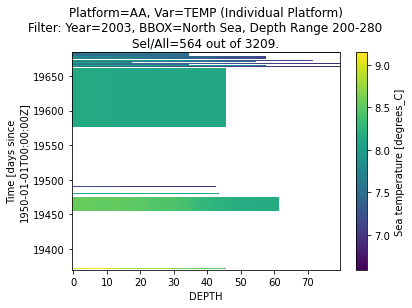

In [46]:
try:
    var = filtered_xarr.name
    print(f"There's only one VAR available from the applied filtered: {var}")
    
    title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Depth Range {depth_start}-{common_depth_stop_abs}\nSel/All={sel_outof_all}'
    
    plotFilteredVar(filtered_xarr, title=title)
    
except:
    myvars = list(filtered_xarr.keys())
    print(f"There are multiple VARs available from the applied filtered: {myvars}")
    
    for var in myvars:
        
        title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Depth Range {depth_start}-{common_depth_stop_abs}\nSel/All={sel_outof_all}'

        plotFilteredVar(filtered_xarr[var], title=title)

#### Plotting individual Variables across aggregated Platforms
Build a dictionary that stores, for each platform and variable combination, the data sliced using the same DEPTH dimension in such a way to generate datasets that can be combined / merged.

**IMPORTANT** make sure to have executed the **Filtered data by BBOX (All Variables)** section, so that you're using the *filtered_arr* array.

##### Generate **filtered_xarr** for all Platforms

In [ ]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
filtered_xarr_dict = {}

for pc in df_toPlot['Platform'].unique():
    
    for var in var_list: 

        xarr = data_dict[pc]['data']
        
        vmin = float(xarr.attrs['geospatial_vertical_min'])

        if vmin == 0:
            print(f'Platform: {pc} - Vertical min = {vmin}')
        elif vmin == 1 and vmin_dict[pc][var]==False:
            xarr_var = xarr[var].data
            print(f'Platform: {pc} - Vertical min = {vmin} --> adjusting')
            data_dict[pc]['data'][var].data = adjust_with_vmin(xarr_var, value=np.nan)
            vmin_dict[pc][var] = True # to avoid doing hte vmin adjustment for this pc/var more than once
        elif vmin_dict[pc][var]==True:
            print(f'Platform: {pc} - Vertical min = {vmin} (adjusted already) --> skipping adjustment')
        #print(f'Dimensions: TIME={xarr_var.shape[0]}, DEPTH={xarr_var.shape[1]}') 
        
        
    filtered_xarr_dict[pc] = filter_xarr(df_toPlot, data_dict, platform=pc, var=var_list, depth_range=[common_depth_start_rel,common_depth_stop_rel])
    
# filtered_xarr_dict

In [ ]:
data_var_dict = {}

for pc in df_toPlot['Platform'].unique(): 
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')

    for var in var_list:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]

# display(data_var_dict)

Definitions:
* min_depth = least common denominator for the DEPTH dimension found amongst the selected platforms
* max_depth = maximum value of the DEPTH dimension found amongst the selected platforms 


In [ ]:
[print(data_var_dict[k]['TEMP'].shape) for k in data_var_dict.keys()]

# Find maximum and minimum DEPTH dimension among the platforms
max_depth = max([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('max_depth:', max_depth)
min_depth = min([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('min_depth:', min_depth)

###### Aggregate with Min_depth
Use minimum DEPTH across the platforms' DEPTHs

In [ ]:
# Use min_depth across available platforms: Reduce size to the minimum dimension 
print(f'Reshaping using minimum DAPTH dimension ({min_depth}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in var_list:
        
        data = data_var_dict[pc][var].isel(DEPTH=slice(0,min_depth)); #display(data_sel)
        
        print(f'{data_var_dict[pc][var].shape} --> {data.shape}')
        
        reshaped_dict[pc][var] = data
        
# reshaped_dict

###### Aggregate with Max_depth
use maximum DEPTH across all platforms' DEPTHs, and fill empty values with nans

Definition of the new xarray.DataArray
```# Create a new xarray.DataArray with same properties but larger DEPTH 
da = xr.DataArray(
    data=new_arr_data, # this is the actual numpy array with the new desired shape
    dims=old_arr.dims, # copy dimensions names from the old array (eg TIME, DEPTH)
    coords=old_arr.coords, # copy coords
    attrs=old_arr.attrs, # copy attrs
    name='PRES' # define var name
)
da
```

In [ ]:
print(f'Reshaping using maximum DEPTH dimension ({max_depth}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in var_list:
        
        arr = data_var_dict[pc][var]
        
        # generate an empty array of nans, to then concatenate to the existing data array, to ensure it matches the desired new dimension DEPTH 
        fill = np.empty((arr.shape[0], max_depth-arr.shape[1]), dtype=arr.dtype); fill[:] = np.nan
        newarr_data = np.concatenate((arr.data,fill), axis=1)
        print(f'{arr.shape} --> {newarr_data.shape}')
        
        # Now create the xarray.DataArray
        newarr = newXDA(arr, newarr_data, var)
        
        reshaped_dict[pc][var] = newarr

# reshaped_dict

##### Plotting Aggregate Results

In [ ]:
# reshaped_dict['AA'][var]

In [ ]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in var_list:
        
    merged_arr[var] = xr.merge([reshaped_dict[pc][var] for pc in reshaped_dict.keys()])  
    
#     print(var, type(merged_arr[var]), merged_arr[var][var].shape) # Note you need double 'var' because the first is the key of teh dictionary, the second is the name of the var to plot
#     display(merged_arr[var])
    
    title = f'Var={var} (Merged Platforms)\nFilter: Year={year}, {bbox_key}, Depth Range {depth_start}-{common_depth_stop_abs}\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)